In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score
import random

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
#sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
#sample2['binned_age'] = sample2['binned_age']+0.5
#df_male = pd.concat([sample,sample2])
df_male = sample.copy()
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [5]:
# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [6]:
df_indv=m_df.groupby(['mouse','age']).mean()
df=df_indv.copy().reset_index()

In [7]:
# choose a model
clf = svm.SVC(kernel='linear') 

# choose cross validation scheme
cv = LeaveOneOut()

#number of iterations for shuffle
it=100

In [8]:
# prepare colors for plot
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
pl = sns.color_palette("dana", n_colors=50)

/tmp/ipykernel_29832/1691959703.py:6: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)


In [9]:
xmale = pd.DataFrame()
a = 0
n=8
nmin=8
age = []
acc = []
sh_acc = []
sh_ages = []
coefficients_list = []

while True:
    # Build the current age matrix
    for m, _df in enumerate(df.groupby('mouse')):
        xmale_temp = _df[1][a:a+n]
        xmale = pd.concat([xmale, xmale_temp])
        
    rep_counts = xmale.groupby('mouse')['age'].size()
    keep_mice = list(rep_counts[rep_counts >= nmin].index)  # keep mice that have at least nmin sessions
    xmale = xmale[xmale['mouse'].isin(keep_mice)]
    if xmale.empty:
        break
    age.append(np.floor(np.mean(xmale['age'])).astype(int))    
    ymale = xmale['mouse']
    x = xmale.drop(['mouse', 'age'], axis=1).to_numpy()
    x=np.log(x+1e-6)
    
    # Fit the model and collect coefficients
    clf.fit(x, ymale)
    coefficients_list.append(np.mean(clf.coef_,axis=0))
    
    # Perform cross-validation
    y_pred = cross_val_predict(clf, x, ymale, cv=cv)
    temp_acc = np.mean(cross_val_score(clf, x, ymale, cv=cv, n_jobs=-1))
    acc.append(temp_acc)
    
    # Shuffle labels and calculate shuffled accuracy
    for i in tqdm(range(it)):
        ysh_temp = np.random.permutation(ymale)
        y_pred_temp = cross_val_score(clf, x, ysh_temp, cv=cv, n_jobs=-1)
        sh_acc.append(np.mean(y_pred_temp))
        sh_ages.append(np.floor(np.mean(xmale['age'])).astype(int))
    
    # Handle variables for the loop
    xmale = pd.DataFrame()
    a = a + 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.13it/s]


In [10]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age

In [11]:
format_plots()

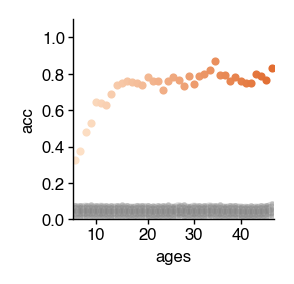

In [12]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
sns.pointplot(data=df_sh, x="ages", y="acc", ax=ax, color='grey',estimator='mean', errorbar=('sd',2),join=True)
plt.setp(ax.collections, alpha=.3) #for the markers
plt.setp(ax.lines, alpha=.3)       #for the lines
sns.pointplot(data=df, x="ages", y="acc",
              dodge=0, 
              join=True, 
              ax=ax, 
              scale=0.5,
              hue='ages',
              palette=pl,
              estimator='mean', errorbar=('sd',2),
             )
plt.legend([],[], frameon=False)
#plt.xticks([])
ax.set_ylim([0,1.1])
xticks = [4, 14, 23, 32]
ax.set_xticks(xticks)
sns.despine()
#ax.set_title('identity classifier male')
c = PlotConfig()

In [13]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'indv_decoder_longv2_female.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

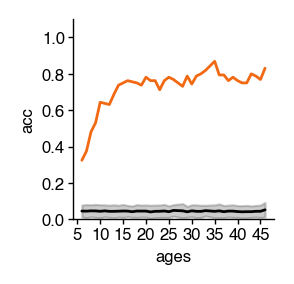

In [27]:
format_plots()
fig, ax = plt.subplots(figsize=(1.3, 1.3))
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='black', estimator='mean', errorbar=('sd', 2))
sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='#f16913', estimator='mean', errorbar=('sd', 2))
plt.ylim([0.0,1.1])
plt.legend([],[], frameon=False)
# Set custom x-ticks
plt.xticks([5, 10, 15, 20, 25, 30, 35,40,45])
sns.despine()

In [28]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'indv_decoder_longv2_female_line.pdf')

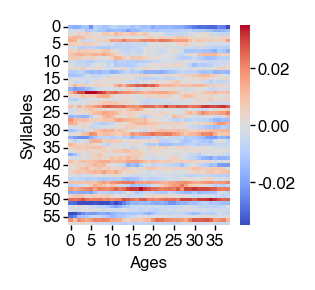

In [16]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
# Convert coefficients list to a DataFrame
coefficients_df = pd.DataFrame(coefficients_list)
sns.heatmap(coefficients_df.T, cmap='coolwarm', center=0, annot=False, fmt='.2f', vmin=-0.035, vmax=0.035)
plt.ylabel('Syllables')
plt.xlabel('Ages')

#tick_positions = [4, 14, 23, 32]
#ax.set_xticks(xticks)
#tick_labels = [age[i] for i in tick_positions]
#plt.xticks(tick_positions, tick_labels)

plt.show()

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'indv_decoder_longv2_coefficient_female.pdf')

In [18]:
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR
X = df_indv.to_numpy()
y = list(df_indv.index.get_level_values('mouse'))
mi_score_id = MIC(X,y)
id_indx = np.argsort(mi_score_id)[::-1][0:len(keep_syllables)] # syllble index
impsyl_id= list(df_indv.columns[id_indx]) #syllable id

In [19]:
# Convert coefficients list to a DataFrame
coef= pd.DataFrame(coefficients_list).T
coef['syll'] = keep_syllables
coef.set_index(['syll'],inplace=True)
# Step 3: Rename the columns
coef.columns = age
coef = coef.reindex(impsyl_id)

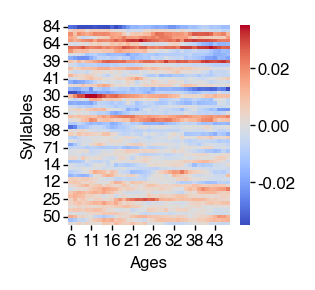

In [20]:
fig, ax = plt.subplots(figsize=(1.3, 1.3))
sns.heatmap(coef, cmap='coolwarm', center=0, annot=False, fmt='.2f', vmin=-0.035, vmax=0.035)
plt.ylabel('Syllables')
plt.xlabel('Ages')

# Set x-axis ticks to show only every 6 ages
#tick_positions = [4, 14, 23, 32]
#ax.set_xticks(xticks)
#tick_labels = [age[i] for i in tick_positions]
#plt.xticks(tick_positions, tick_labels)

plt.show()

In [21]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'indv_decoder_longv2_coefficient_resorted_female.pdf')

/tmp/ipykernel_29832/1820509428.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, orientation='horizontal', ticks=range(num_colors))


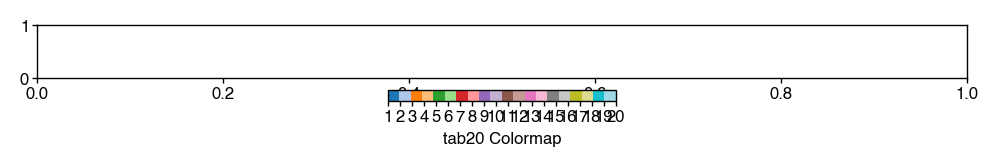

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define the number of colors in the tab20 colormap
num_colors = 20

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

# Create a colormap object
cmap = plt.get_cmap('tab20', num_colors)

# Create a ScalarMappable with the colormap and normalize it
norm = mcolors.Normalize(vmin=0, vmax=num_colors-1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add a color bar to the plot
cbar = fig.colorbar(sm, orientation='horizontal', ticks=range(num_colors))

# Set the color bar ticks and labels
cbar.ax.set_xticklabels([str(i) for i in range(1, num_colors+1)])
cbar.set_label('tab20 Colormap')

# Show the plot
plt.show()

In [23]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig4"/ 'longv2_indv_colormap.pdf')